# Warning :
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.


In [3]:
import argparse
import os
import time
!pip install optuna
import optuna
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from optuna.trial import TrialState


import PIL
from PIL import Image

import numpy as np
import torchvision
import pickle

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable

from sklearn.svm import LinearSVC

# Partie 1 : Architecture VGG16

In [4]:
#!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/imagenet_classes.pkl
!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/imagenet_classes.pkl

# Bonus : Classifiez des exemples avec vgg16 et commentez le résultat dans votre rapport.
!wget --content-disposition https://unsplash.com/photos/gKXKBY-C-Dk/download?force=true -O cat.jpg
!wget --content-disposition https://unsplash.com/photos/qO-PIF84Vxg/download?force=true -O dog.jpg

zsh:1: command not found: wget
zsh:1: no matches found: https://unsplash.com/photos/gKXKBY-C-Dk/download?force=true
zsh:1: no matches found: https://unsplash.com/photos/qO-PIF84Vxg/download?force=true


In [5]:


image_files = [
    "20220211142754-margherita-9920_5a73220e-4a1a-4d33-b38f-26e98e3cd986.jpg",
    "Stone-fruit_1024x1024.jpg.webp",
    "images-3.jpeg",
    "images-2.jpeg",
    "TOC-Autumn24-Ruby-crowned_Kinglet-Christopher_T-ML609692481-FI-480x360.jpg",
    "images.jpeg",
    "Orange-colored-cat-yawns-displaying-teeth.jpg.webp"
]
# Loding pre-trained VGG
vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16.eval()

n_images = len(image_files)
n_cols = 3
n_rows = (n_images + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))

for i, nameim in enumerate(image_files):
  img = Image.open(nameim)
  axes.flat[i].imshow(img)

  # Loading ImageNet classes
  imagenet_classes = pickle.load(open('imagenet_classes.pkl', 'rb'))

  # Normalization
  img = img.resize((224, 224), Image.BILINEAR)
  img = np.array(img, dtype=np.float32) / 255
  img = torch.from_numpy(img).permute(2, 0, 1)  # Convert to Tensor and reorder to (C, H, W)
  # ImageNet mean/std
  mu = torch.Tensor([0.485, 0.456, 0.406])
  sigma = torch.Tensor([0.229, 0.224, 0.225])
  # Expand mu & sigma to match image size
  mu = mu.view(3, 1, 1)
  sigma = sigma.view(3, 1, 1)
  # compute the normalized image with mean ImageNet image
  img = (img - mu) / sigma

  # Forward pass on VGG
  x = img.unsqueeze(0)
  with torch.no_grad():
    y = vgg16(x)
  y = y.numpy() # transformation en array numpy

  # Get prediction (i.e., ImageNet class label)
  predicted_index = np.argmax(y)

  # Ensure img is a Tensor and perform operations
  img_denorm = img
  # Convert to (H, W, C) format for imshow
  img_denorm = img_denorm.permute(1, 2, 0).numpy()  # Convert to NumPy
  axes.flat[i].imshow(img_denorm)


  axes.flat[i].set_title(imagenet_classes[predicted_index])

for i in range(0,3):
  for j in range(0, len(axes)):
    axes[i][j].axis('off')

plt.show()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/niccolozoboli/.cache/torch/hub/checkpoints/vgg16-397923af.pth


URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:992)>

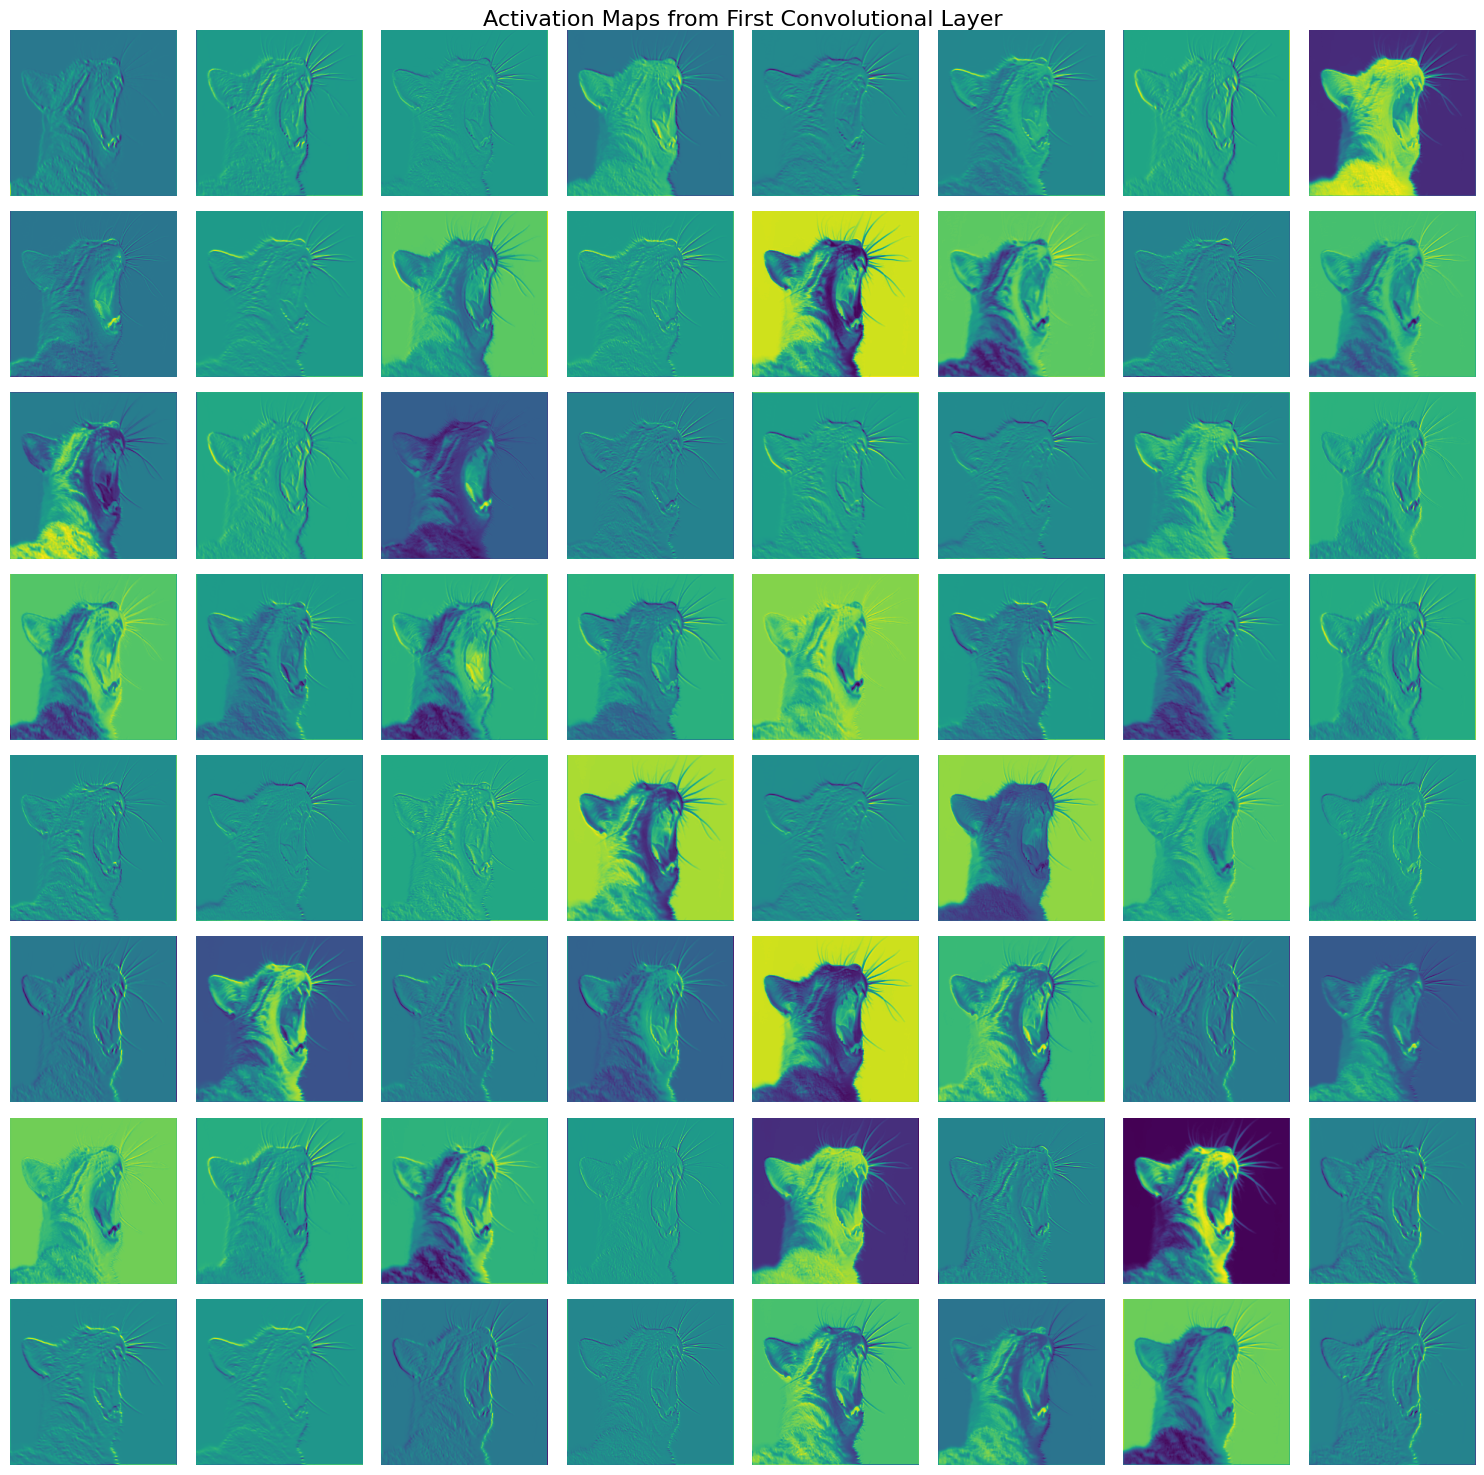

In [ ]:
#Visualize several activation maps obtained after the first convolutional layer. How can we interpret them?
fig, axes = plt.subplots(8, 8, figsize=(15, 15))  # Assuming 64 filters in the first layer

# Extract the activations from the first convolutional layer
first_conv_layer = vgg16.features[0]  # Access the first conv layer
with torch.no_grad():
    activations = first_conv_layer(x)  # Shape: (1, 64, 224, 224)

# Plot each activation map
for i, ax in enumerate(axes.flat):
    if i < activations.shape[1]:  # Limit to the number of filters (channels)
        ax.imshow(activations[0, i].cpu().numpy(), cmap='viridis')  # Convert to NumPy
        ax.axis('off')
    else:
        ax.axis('off')

plt.suptitle("Activation Maps from First Convolutional Layer", fontsize=16)
plt.tight_layout()
plt.show()

# Partie 2: Transfer Learning avec VGG16 sur 15 Scene

In [ ]:
#!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/15ScenesData.zip
!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/15ScenesData.zip

!unzip 15ScenesData.zip

--2024-12-23 11:36:49--  https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/15ScenesData.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/15ScenesData.zip [following]
--2024-12-23 11:36:49--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/15ScenesData.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86520868 (83M) [application/zip]
Saving to: ‘15ScenesData.zip’

15ScenesData.zip    100%[===================>]  82.51M   341MB/s    in 0.2s    

2024-12-23 11:36:52 (341 MB/s) - ‘15ScenesData.zip’ saved [86520868/86520868]

In [6]:
ls 15SceneData/test/bedroom/

ls: 15SceneData/test/bedroom/: No such file or directory


In [7]:
class VGG16relu17(nn.Module):
  def __init__(self, layer):
    super(VGG16relu17, self).__init__()
    self.features = nn.Sequential( *list(vgg16.features.children()))
    self.classifier = nn.Sequential(*list(vgg16.classifier.children())[:layer+1])
  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x

In [8]:
def get_dataset(batch_size, path, fraction=0.3):
    # This function expands 3 times a gray level image
    def duplicateChannel(img):
        img = img.convert('L')
        np_img = np.array(img, dtype=np.uint8)
        np_img = np.dstack([np_img, np_img, np_img])
        img = Image.fromarray(np_img, 'RGB')
        return img

    def resizeImage(img):
        return img.resize((224, 224), Image.BILINEAR)

    #####################
    ## YOUR CODE HERE  ##
    #####################
    # Add pre-processing
    train_dataset = datasets.ImageFolder(
        path + '/train',
        transform=transforms.Compose([
            transforms.Lambda(duplicateChannel),
            transforms.Lambda(resizeImage),
            transforms.ToTensor(),
            transforms.Normalize(mu, sigma)
        ])
    )
    val_dataset = datasets.ImageFolder(
        path + '/test',
        transform=transforms.Compose([
            transforms.Lambda(duplicateChannel),
            transforms.Lambda(resizeImage),
            transforms.ToTensor(),
            transforms.Normalize(mu, sigma)
        ])
    )

    # Reduce dataset by fraction
    if fraction < 1.0:
        train_indices = np.random.choice(len(train_dataset), int(len(train_dataset) * fraction), replace=False)
        train_dataset = torch.utils.data.Subset(train_dataset, train_indices)

        val_indices = np.random.choice(len(val_dataset), int(len(val_dataset) * fraction), replace=False)
        val_dataset = torch.utils.data.Subset(val_dataset, val_indices)

    ####################
    ##      END        #
    ####################

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader

In [11]:
def extract_features(data, model, in_dim=4096):
    # Initialize lists to store features and labels
    features_list = []
    labels_list = []

    for i, (input, target) in enumerate(data):
        print('Batch {0:03d}/{1:03d}'.format(i, len(data)))

        # Move input to device
        input = input
        target = target

        # Ensure no gradients are computed, saving memory
        with torch.no_grad():
            # Feature extraction
            features = model(input)
            # Correct normalization
            features = features / torch.norm(features, dim=1, keepdim=True)

        features_list.append(features)
        labels_list.append(target)

    # Concatenate all features and labels
    X = torch.cat(features_list, dim=0)
    y = torch.cat(labels_list, dim=0)

    return X, y

def main(path="15SceneData", batch_size=8, model = vgg16, in_dim = 4096):



    model.eval()


    # On récupère les données
    print('Récupération des données')
    train, test = get_dataset(batch_size, path)

    # Extraction des features
    print('Feature extraction')
    X_train, y_train = extract_features(train, model, in_dim)
    X_test, y_test = extract_features(test, model, in_dim)

    #####################
    ## Votre code ici  ##
    #####################
    # Apprentissage et évaluation des SVM à faire
    print('Apprentissage des SVM')
    accuracy = 0

    svm = LinearSVC(C=1.0)
    svm.fit(X_train, y_train)
    accuracy = svm.score(X_test, y_test)


    ####################
    ##      FIN        #
    ####################
    print('Accuracy = %f' % accuracy)
    return svm


In [ ]:
class final_model(nn.Module) :
  def __init__(self,  model, classifier) :
    super().__init__()
    self.model = model
    self.classifier = classifier

  def forward(self, x) :
    x = self.model(x)
    x = self.classifier(x)
    return x

  def predict(self, x) :
    x = self.model(x)
    x = self.classifier(x)
    return x

In [ ]:
vgg16 = models.vgg16(pretrained=True)
model = VGG16relu17(vgg16)
svm = main("15SceneData", 32, model, in_dim = 4096)
svm_vgg = final_model(model, svm)

# Changing layer of extraction

In [ ]:
class VGG16early(nn.Module):
  def __init__(self, vgg16):
    super().__init__()
    # Copy the entire convolutional part
    self.features = nn.Sequential(*list(vgg16.features.children()))


  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)

    return x

In [ ]:
model = VGG16early(vgg16)
svm = main("15SceneData", 32, model, in_dim = 25088)
vggearly_svm = final_model(model ,svm)

# Using another pre-trained model : ViT-Transformer

In [ ]:
import timm

vit = timm.create_model('vit_base_patch16_224', pretrained=True)

class vit_partial(nn.Module):
  def __init__(self, vit):
    super().__init__()
    self.layers = nn.Sequential(*list(vit.children())[:-1])

  def forward(self, x):
    x = self.layers(x)
    x = x.view(x.size(0), -1)
    return x



In [ ]:
model = vit_partial(vit)
svm = main("15SceneData", 8, model)
svm_vit = final_model(model, svm)


# Optimization of C via Optuna

In [ ]:
def main_optuna(path="15SceneData", batch_size=4, model = vgg16):



    model.eval()


    # On récupère les données
    print('Récupération des données')
    train, test = get_dataset(batch_size, path)

    # Extraction des features
    print('Feature extraction')
    X_train_full, y_train_full = extract_features(train, model)
    X_test, y_test = extract_features(test, model)
    X_train, X_val, y_train, y_val = train_test_split(
                  X_train_full, y_train_full, test_size=0.2, random_state=42
              )

    #####################
    ## Votre code ici  ##
    #####################
    # Apprentissage et évaluation des SVM à faire
    print('Apprentissage des SVM')
    accuracy = 0
    def objective(trial):
      c = trial.suggest_float('C', 1e-10, 1e10, log=True)
      svm = LinearSVC(C = c)

      svm.fit(X_train, y_train)
      accuracy = svm.score(X_val, y_val)
      return accuracy

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)
    best_c = study.best_params['C']
    print("Best parameter C : ", best_c)
    svm = LinearSVC(C = best_c)
    svm.fit(X_train_full,y_train_full)
    test_accuracy = svm.score(X_test, y_test)
    ####################
    ##      FIN        #
    ####################

    print("Accuracy on test : ", test_accuracy )
    return svm

In [ ]:
vgg16 = models.vgg16(pretrained=True)
model = VGG16relu17(vgg16)
svm = main_optuna("15SceneData", 32, model)

# Full VGG16 with 15 classes instead of 1000

In [ ]:
class VGG16full_15(nn.Module):

  def __init__(self, vgg16):
    super().__init__()
    # Copy the entire convolutional part
    self.features = nn.Sequential(*list(vgg16.features.children()))
    self.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-1])


  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x


class last_layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(4096, 15)

    def forward(self, x):
        x = self.linear(x)
        return x



In [ ]:
#We train just the last layer
train, test = get_dataset(32, "15SceneData")

vgg16 = torchvision.models.vgg16(pretrained=True)

model = VGG16relu17(vgg16)

batch_size = 32

X_train, y_train = extract_features(train, model)

X_test, y_test = extract_features(test, model)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR



class_layer = last_layer()

optimizer = torch.optim.SGD(class_layer.parameters(), lr = 0.1)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
criterion = nn.CrossEntropyLoss()
batch_size = 32

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
epochs = 1000



for i in range(epochs + 1):
    class_layer.train()
    for batch_x, batch_y in train_loader:

        output = class_layer(batch_x)

        loss = criterion(output, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    if (i+1)%100==0 and i!=0:
      print(f"Loss (Train) - Epoch {i+1}: {loss.item()}")

class_layer.eval()
with torch.no_grad():

  total_loss = 0
  correct = 0
  total = 0
  for batch_x, batch_y in test_loader:
        # Estrai le feature dal modello
      output_test = class_layer(batch_x)  # Passa le feature al classificatore

      # Calcola il loss
      loss_test = criterion(output_test, batch_y)
      total_loss += loss_test.item()

      # Calcola l'accuracy
      _, predicted = torch.max(output_test, 1)
      total += batch_y.size(0)
      correct += (predicted == batch_y).sum().item()

  print(f'Epoch {i}/{epochs}, Loss (Test): {total_loss / len(test):.4f}, Accuracy (Test): {correct / total * 100:.2f}%')

In [ ]:
vgg_linear = final_model(model, class_layer)

# Dimensionality Reduction


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC

class PCA_SVM_Model(nn.Module):
    def __init__(self, feature_extractor, pca, svm):
        super(PCA_SVM_Model, self).__init__()
        self.feature_extractor = feature_extractor
        self.pca = pca
        self.svm = svm

    def forward(self, x):
        # Extract features with the PyTorch model
        features = self.feature_extractor(x)
        features = features.detach().numpy().T  # Convert to numpy for PCA/SVM
        features_reduced = self.pca.transform(features)  # Apply PCA
        predictions = self.svm.predict(features_reduced)  # Predict with SVM
        return torch.tensor(predictions)  # Convert back to PyTorch tensor

In [ ]:
vgg16 = torchvision.models.vgg16(pretrained=True)

model = VGG16relu17(vgg16)

batch_size = 32
train, test = get_dataset(batch_size, "15SceneData")

X_train, y_train = extract_features(train, model)


k=400
pca = PCA(n_components=k)
X_train_reduced = pca.fit_transform(X_train.numpy())


svm = LinearSVC(C=1.0)

svm.fit(X_train_reduced, y_train.numpy())


X_test, y_test = extract_features(test, model)

X_test_reduced = pca.transform(X_test.numpy())
accuracy = svm.score(X_test_reduced, y_test.numpy())
print("Accuracy : ", accuracy)



final_model = PCA_SVM_Model(model, pca, svm)

In [12]:
X_train, X_test, y_train, y_test = main("15SceneData", 8,-3)

Instanciation de VGG16


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/niccolozoboli/.cache/torch/hub/checkpoints/vgg16-397923af.pth


URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:992)>

In [13]:
# Apprentissage et évaluation des SVM à faire
print('Apprentissage des SVM')
accuracy = 0

#According to the pdf file provided, we train an SVM on the training set
#With C = 1

svm = LinearSVC(C=1.0).fit(X_train, y_train)
y_hat = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_hat)
print(f"Accuracy = {round(accuracy*100,2)} %")

Apprentissage des SVM


NameError: name 'X_train' is not defined